In [79]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands

## Power Calcs

In [111]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115, 202]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        if not is_post_stim:
            trial_num += 1
            shock_num = 0
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Reading 0 ... 51647  =      0.000 ...   206.588 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 251 original time points ...
0 bad epochs dropped
((), (),

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


Opening raw data file data/202/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51383 =      0.000 ...   205.532 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 251 original time points ...
3 bad epochs dropped
((), (), ('BAD_',), (), (), (), (), (), (), (), (), (), (), ('BAD_',), (), (), (), ('BAD_',), ())


ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  7.676245e-08  7.966128e-08   
1    100  False     1  LHip3 - LHip4  7.599882e-08  5.435899e-08   
2    100  False     1  LatT1 - LatT2  1.777491e-09  1.945915e-09   
3    100  False     1  LatT3 - LatT4  1.063224e-08  1.579306e-08   
4    100   True     1  LHip1 - LHip2  1.142425e-07  7.161263e-08   
..   ...    ...   ...            ...           ...           ...   
623  202   True     3    LHT3 - LHT4  1.042007e-08  8.687519e-10   
624  202   True     3    LOT1 - LOT2  1.898780e-08  4.586229e-09   
625  202   True     3    LOT3 - LOT4  8.277882e-09  4.419796e-09   
626  202   True     3    LHT1 - LHT2  3.353753e-09  1.279668e-09   
627  202   True     3    LHT3 - LHT4  1.437498e-08  1.089688e-09   

            Alpha          Beta     GammaHigh      GammaLow      GammaMed  \
0    3.897899e-08  1.350653e-08  1.342159e-10  1.014126e-09  2.448737e-10   
1    7.955522e-09  3.615457e-09  5.158829e-11  8.472699e-10  8.771663e-11   
2    7.836614e-10  2.448647e-10  1.145110e-11  5.035184e-11  1.546049e-11   
3    8.962653e-09  1.447087e-09  2.411582e-11  2.195220e-10  4.948296e-11   
4    2.537439e-08  1.169223e-08  9.841945e-11  9.902345e-10  3.155199e-10   
..            ...           ...           ...           ...           ...   
623  1.712772e-09  5.998392e-10  1.263479e-11  4.582474e-11  1.437073e-11   
624  3.352016e-09  2.677703e-09  2.795191e-11  3.338441e-10  9.118730e-11   
625  5.411698e-09  2.388939e-09  2.591528e-11  1.987887e-10  9.733117e-11   
626  7.131607e-10  4.481172e-10  1.177992e-11  9.922757e-11  2.966367e-11   
627  8.153352e-10  3.662438e-10  9.421769e-12  5.989246e-11  1.964661e-11   

       GammaXHigh  Stim_Num  
0    3.160809e-11       0.0  
1    2.150510e-11       0.0  
2    7.259526e-12       0.0  
3    2.017395e-11       0.0  
4    4.089712e-11       1.0  
..            ...       ...  
623  7.864872e-12       4.0  
624  1.372056e-11       6.0  
625  1.321946e-11       6.0  
626  1.306017e-11       6.0  
627  5.984564e-12       6.0  

[628 rows x 13 columns]

In [112]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')

for freq in freqs:
    rearranged[freq+'_pct'] = (rearranged[freq+'_post'] - rearranged[freq+'_pre']) / rearranged[freq+'_pre'] * 100

In [113]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg = power_log_chg.drop(freq+'_pct', axis=1)
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
495  202     3    LHT1 - LHT2  3.353753e-09  1.279668e-09  7.131607e-10   
496  202     3    LHT3 - LHT4  5.957625e-09  1.662203e-09  7.292102e-10   
497  202     3    LHT3 - LHT4  1.140535e-08  1.126939e-09  8.131701e-10   
498  202     3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   
499  202     3    LHT3 - LHT4  1.437498e-08  1.089688e-09  8.153352e-10   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   
2    1.402683e-08    1.111660e-10   9.843672e-10   1.900451e-10  ...   
3    9.420390e-09    8.058547e-11   5.373972e-10   1.538000e-10  ...   
4    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
..            ...             ...            ...            ...  ...   
495  4.481172e-10    1.177992e-11   9.922757e-11   2.966367e-11  ...   
496  4.810947e-10    1.091951e-11   3.770633e-11   2.856315e-11  ...   
497  4.845502e-10    1.317265e-11   6.965751e-11   2.003857e-11  ...   
498  5.998392e-10    1.263479e-11   4.582474e-11   1.437073e-11  ...   
499  3.662438e-10    9.421769e-12   5.989246e-11   1.964661e-11  ...   

     GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  \
0    2.448737e-10    3.160809e-11       0.172679      -0.046258   
1    2.448737e-10    3.160809e-11      -0.119037      -0.392225   
2    2.448737e-10    3.160809e-11      -0.177487      -0.352190   
3    2.448737e-10    3.160809e-11       0.051310       0.002394   
4    8.771663e-11    2.150510e-11       0.697190       0.141332   
..            ...             ...            ...            ...   
495  3.122117e-11    8.304642e-12      -0.116665      -0.522665   
496  2.233407e-11    5.568671e-12       0.472117      -0.290108   
497  2.233407e-11    5.568671e-12       0.754152      -0.458892   
498  2.233407e-11    5.568671e-12       0.714914      -0.571896   
499  2.233407e-11    5.568671e-12       0.854651      -0.473490   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.271439     -0.209959          0.082064          0.065601   
2        -0.037361      0.016416         -0.012935         -0.110085   
3         0.071756     -0.156475         -0.275796         -0.201986   
4        -0.126444     -0.027167         -0.000208          0.235129   
..             ...           ...               ...               ...   
495      -0.304527     -0.048449          0.083974         -0.022224   
496      -0.340826     -0.079960         -0.246168          0.106838   
497      -0.293497     -0.076852          0.020386         -0.047101   
498       0.030021      0.015844         -0.161482         -0.191489   
499      -0.292343     -0.198421         -0.045210         -0.055680   

     GammaHigh_log_chg  GammaXHigh_log_chg  
0            -0.134723            0.111894  
1             0.038881            0.058941  
2            -0.081832           -0.153179  
3            -0.221547            0.139011  
4             0.192664            0.121860  
..                 ...                 ...  
495          -0.208845            0.196628  
496           0.035951           -0.026124  
497           0.117421            0.048646  
498           0.099316            0.149940  
499          -0.028120            0.031281  

[500 rows x 28 columns]

## Get Memory Data

In [114]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)

memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [115]:
power_and_mem = power_log_chg.merge(memory_trials, on=['ID', 'Trial'], how='left')
power_and_mem = power_and_mem.dropna()
memory_delayed = pd.read_csv('memory_delayed.csv').iloc[:,1:]
memory_delayed = memory_delayed.rename({'Memory_Stim': 'Delay_Mem_Stim', 'Memory_Sham': 'Delay_Mem_Sham'}, axis=1)
power_and_mem = power_and_mem.merge(memory_delayed, on='ID', how='left')
power_and_mem

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
463  202     3    LHT1 - LHT2  3.353753e-09  1.279668e-09  7.131607e-10   
464  202     3    LHT3 - LHT4  5.957625e-09  1.662203e-09  7.292102e-10   
465  202     3    LHT3 - LHT4  1.140535e-08  1.126939e-09  8.131701e-10   
466  202     3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   
467  202     3    LHT3 - LHT4  1.437498e-08  1.089688e-09  8.153352e-10   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   
2    1.402683e-08    1.111660e-10   9.843672e-10   1.900451e-10  ...   
3    9.420390e-09    8.058547e-11   5.373972e-10   1.538000e-10  ...   
4    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
..            ...             ...            ...            ...  ...   
463  4.481172e-10    1.177992e-11   9.922757e-11   2.966367e-11  ...   
464  4.810947e-10    1.091951e-11   3.770633e-11   2.856315e-11  ...   
465  4.845502e-10    1.317265e-11   6.965751e-11   2.003857e-11  ...   
466  5.998392e-10    1.263479e-11   4.582474e-11   1.437073e-11  ...   
467  3.662438e-10    9.421769e-12   5.989246e-11   1.964661e-11  ...   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.271439     -0.209959          0.082064          0.065601   
2        -0.037361      0.016416         -0.012935         -0.110085   
3         0.071756     -0.156475         -0.275796         -0.201986   
4        -0.126444     -0.027167         -0.000208          0.235129   
..             ...           ...               ...               ...   
463      -0.304527     -0.048449          0.083974         -0.022224   
464      -0.340826     -0.079960         -0.246168          0.106838   
465      -0.293497     -0.076852          0.020386         -0.047101   
466       0.030021      0.015844         -0.161482         -0.191489   
467      -0.292343     -0.198421         -0.045210         -0.055680   

     GammaHigh_log_chg  GammaXHigh_log_chg  Avg_Sham  Memory_Score  \
0            -0.134723            0.111894  7.666667           4.0   
1             0.038881            0.058941  7.666667           4.0   
2            -0.081832           -0.153179  7.666667           4.0   
3            -0.221547            0.139011  7.666667           4.0   
4             0.192664            0.121860  7.666667           4.0   
..                 ...                 ...       ...           ...   
463          -0.208845            0.196628  5.333333           7.0   
464           0.035951           -0.026124  5.333333           7.0   
465           0.117421            0.048646  5.333333           7.0   
466           0.099316            0.149940  5.333333           7.0   
467          -0.028120            0.031281  5.333333           7.0   

     Delay_Mem_Stim  Delay_Mem_Sham  
0               4.0               5  
1               4.0               5  
2               4.0               5  
3               4.0               5  
4               4.0               5  
..              ...             ...  
463             5.0               2  
464             5.0               2  
465             5.0               2  
466             5.0               2  
467             5.0               2  

[468 rows x 32 columns]

In [116]:
power_log_chg = pd.read_csv('pre_post_stim.csv')

In [117]:
three_word_groups = pd.read_csv('three_words_delay.csv')

In [118]:
# pt 103 had 5 stims on trials 2 and 3. We'll asssume that the 5th was administered after all 12 words were presented
power_log_chg = power_log_chg[power_log_chg['Stim_Num'] != 5]
power_mem_3 = power_log_chg.merge(three_word_groups, left_on='ID', right_on='Participant_Number')

In [119]:
power_mem_3['Prev_Trio'] = power_mem_3.loc[power_mem_3['Stim_Num'] == 1, 'Words_1_3']
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2), 'Words_4_6'])
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3), 'Words_7_9'])
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 4), 'Words_10_12'])

In [120]:
power_mem_3['Next_Trio'] = power_mem_3.loc[power_mem_3['Stim_Num'] == 1, 'Words_4_6']
power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2), 'Words_7_9'])
power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3), 'Words_10_12'])

In [121]:
power_mem_3 = power_mem_3.dropna()

## Averaging

In [123]:
power_mem_trial = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    power_and_mem[x_for_freq] = np.log10(power_and_mem[x_for_freq])
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    power_and_mem[x_for_freq] = np.log10(power_and_mem[x_for_freq])
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        power_mem_trial[col] = df_mems[col]
power_mem_trial = power_mem_trial.reset_index()

In [124]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

In [125]:
power_mem_4 = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    power_mem_3[x_for_freq] = np.log10(power_mem_3[x_for_freq])
    power_mem_4[x_for_freq] = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    power_mem_3[x_for_freq] = np.log10(power_mem_3[x_for_freq])
    power_mem_4[x_for_freq] = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_4[x_for_freq] = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num'])[x_for_freq].mean()
    
df_mems = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num']).mean()
for col in df_mems.columns:
    if col in ['Prev_Trio', 'Next_Trio']:
        power_mem_4[col] = df_mems[col]
power_mem_3 = power_mem_4.reset_index()

In [126]:
raise Exception()

Exception: 

## End Setup

## PRE-Stim Power

RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaMed: r = 0.7886304209812275, p = 0.00010069993500367756
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaMed: r = 0.6216978166665508, p = 0.013350208341817537


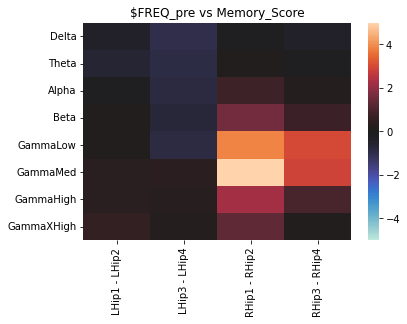

In [ ]:
make_heatmap(power_mem_trial, '$FREQ_pre', 'Memory_Score')

LHip3 - LHip4 Alpha: r = -0.35336495502507387, p = 0.006509402459079413
LHip3 - LHip4 Beta: r = -0.29208324736556746, p = 0.02609625242322543
RHip1 - RHip2 GammaLow: r = 0.3706491785548419, p = 0.004181793983379667
RHip1 - RHip2 GammaMed: r = 0.300511729259011, p = 0.02190174065995956


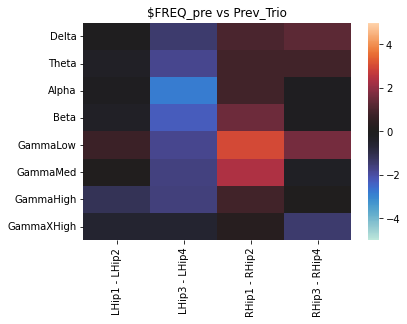

In [ ]:
make_heatmap(power_mem_3, '$FREQ_pre', 'Prev_Trio')

LHip3 - LHip4 Delta: r = -0.39064309893986116, p = 0.0024314512384983073
LHip3 - LHip4 Theta: r = -0.3056986828671483, p = 0.019615657864866392
RHip1 - RHip2 Beta: r = 0.37540342443757013, p = 0.003686996134250997
RHip1 - RHip2 GammaLow: r = 0.5664597351120849, p = 3.5698653636645627e-06
RHip1 - RHip2 GammaMed: r = 0.4847599178512427, p = 0.00011516003002627852
RHip1 - RHip2 GammaHigh: r = 0.3700684091641101, p = 0.004246083854678798
RHip3 - RHip4 Beta: r = 0.30455890217249654, p = 0.03336110238858576
RHip3 - RHip4 GammaLow: r = 0.4552785840601869, p = 0.001012782972501829


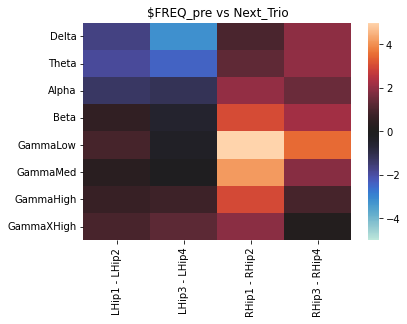

In [ ]:
make_heatmap(power_mem_3, '$FREQ_pre', 'Next_Trio')

In [ ]:
from scipy.stats import linregress

def calc_stats_linreg(df, x, y, freqs, xlabel=None, ylabel=None):
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y
    t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
    pvals = pd.DataFrame()
    rvals = pd.DataFrame()
    for i, chan in enumerate(hip_chans):
        power_for_chan = df[df['Channel'] == chan]
        for j, freq in enumerate(freqs):
            if 'log_chg' in x:
                results = linregress(power_for_chan[x.replace('$FREQ', freq)], power_for_chan[y])
            else:
                results = linregress(np.log10(power_for_chan[x.replace('$FREQ', freq)]), power_for_chan[y])
            t_arr[i][j] = results.slope / results.stderr
            pvals.loc[chan, freq] = results.pvalue
            rvals.loc[chan, freq] = results.rvalue

    return rvals, pvals

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_trial, '$FREQ_pre', 'Memory_Score', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals.loc['RHip1 - RHip2', 'GammaMed']
fdr_bh(pvals)

0.7886304209812275


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.918498  0.918498  0.918498  0.918498  0.918498  0.918498   
LHip3 - LHip4  0.918498  0.918498  0.918498  0.918498  0.918498  0.918498   
RHip1 - RHip2  0.918498  0.918498  0.918498  0.703219  0.023037  0.003222   
RHip3 - RHip4  0.918498  0.918498  0.918498  0.918498  0.106802  0.106802   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.918498    0.918498  
LHip3 - LHip4   0.918498    0.918498  
RHip1 - RHip2   0.268971    0.918498  
RHip3 - RHip4   0.918498    0.918498

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_3, '$FREQ_pre', 'Next_Trio', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals.loc['RHip1 - RHip2', 'GammaMed']


nan


Delta  Theta  Alpha  Beta  GammaLow  GammaMed  GammaHigh  \
LHip1 - LHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
LHip3 - LHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip1 - RHip2    NaN    NaN    NaN   NaN       NaN       NaN        NaN   
RHip3 - RHip4    NaN    NaN    NaN   NaN       NaN       NaN        NaN   

               GammaXHigh  
LHip1 - LHip2         NaN  
LHip3 - LHip4         NaN  
RHip1 - RHip2         NaN  
RHip3 - RHip4         NaN

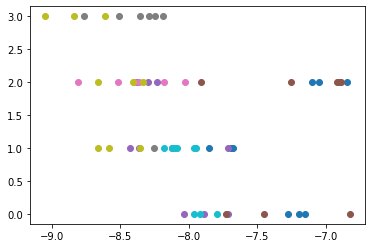

In [ ]:
for pt_num in power_mem_3['ID'].unique():
    power_for_chan = power_mem_3[(power_mem_3['Channel'] == 'LHip3 - LHip4') & (power_mem_3['ID'] == pt_num)]
    plt.scatter(np.log10(power_for_chan['Delta_pre']), power_for_chan['Next_Trio'])

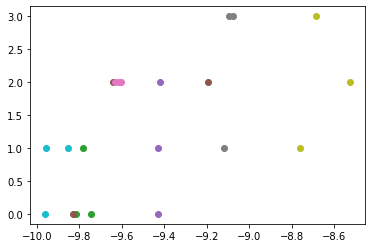

In [139]:
for pt_num in power_mem_3['ID'].unique():
    power_for_chan = power_mem_3[(power_mem_3['Channel'] == 'RHip1 - RHip2') & (power_mem_3['ID'] == pt_num)]
    plt.scatter(power_for_chan['GammaLow_pre'], power_for_chan['Next_Trio'])

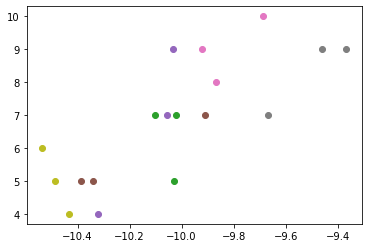

In [137]:
for pt_num in power_mem_trial['ID'].unique():
    power_for_chan = power_mem_trial[(power_mem_trial['Channel'] == 'RHip1 - RHip2') & (power_mem_trial['ID'] == pt_num)]
    plt.scatter(power_for_chan['GammaMed_pre'], power_for_chan['Memory_Score'])

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_trial, '$FREQ_post', 'Memory_Score', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals

0.5348268877420973


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
LHip1 - LHip2  0.278850  0.414895  0.587179  0.902065  0.876203  0.914638   
LHip3 - LHip4  0.043144  0.024828  0.135704  0.216077  0.324543  0.733636   
RHip1 - RHip2  0.550011  0.466391  0.480347  0.241184  0.060112  0.022203   
RHip3 - RHip4  0.745614  0.738096  0.843896  0.806851  0.233665  0.334681   

               GammaHigh  GammaXHigh  
LHip1 - LHip2   0.731103    0.985048  
LHip3 - LHip4   0.863463    0.959232  
RHip1 - RHip2   0.086417    0.201186  
RHip3 - RHip4   0.492996    0.850825

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_3, '$FREQ_post', 'Prev_Trio', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
fdr_bh(pvals)

0.24211957051352662


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.943816  0.943816  0.943816  0.943816  0.983182  0.977547   
LHip3 - LHip4  0.943816  0.943816  0.943816  0.943816  0.943816  0.943816   
RHip1 - RHip2  0.943816  0.977547  0.943816  0.977547  0.943816  0.943816   
RHip3 - RHip4  0.943816  0.949868  0.943816  0.943816  0.943816  0.943816   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.943816    0.943816  
LHip3 - LHip4   0.943816    0.943816  
RHip1 - RHip2   0.943816    0.977547  
RHip3 - RHip4   0.943816    0.943816

In [134]:
import statsmodels.formula.api as smf
def calc_stats_mixed(df, x, y, freqs, xlabel=None, ylabel=None):
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y

    tvals = pd.DataFrame()
    coeffs = pd.DataFrame()
    pvals = pd.DataFrame()
    for i, chan in enumerate(hip_chans):
        power_for_chan = df[df['Channel'] == chan]

        formula = y + " ~ "
        for j, freq in enumerate(freqs):
            var = x.replace('$FREQ', freq) # if 'log_chg' in x else "np.log10("+x.replace('$FREQ', freq)+")"
            formula = y + " ~ " + var
            model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
            result = model.fit()
            tvals.loc[chan, freq] = result.tvalues[1]
            coeffs.loc[chan, freq] = result.params[1]
            pvals.loc[chan, freq] = result.pvalues[1]

    return coeffs, pvals

In [ ]:
coeffs, pvals = calc_stats_mixed(power_mem_trial, '$FREQ_pre', 'Memory_Score', freqs)
fdr_bh(pvals)

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
LHip3 - LHip4  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
RHip1 - RHip2  0.909684  0.909684  0.909684  0.909684  0.003835  0.000241   
RHip3 - RHip4  0.909684  0.909684  0.909684  0.909684  0.197317  0.088857   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.909684    0.909684  
LHip3 - LHip4   0.909684    0.909684  
RHip1 - RHip2   0.682873    0.909684  
RHip3 - RHip4   0.909684    0.909684

In [135]:
coeffs, pvals = calc_stats_mixed(power_mem_trial, '$FREQ_pre', 'Memory_Score', freqs)
fdr_bh(pvals)

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
LHip3 - LHip4  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
RHip1 - RHip2  0.909684  0.909684  0.909684  0.909684  0.003835  0.000241   
RHip3 - RHip4  0.909684  0.909684  0.909684  0.909684  0.197317  0.088857   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.909684    0.909684  
LHip3 - LHip4   0.909684    0.909684  
RHip1 - RHip2   0.682873    0.909684  
RHip3 - RHip4   0.909684    0.909684

In [ ]:
coeffs

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
LHip1 - LHip2  0.669728  0.566166  1.409796  1.104666  0.487972  0.556345   
LHip3 - LHip4  0.283729  0.173781  0.437125  0.223755 -0.623266  2.052141   
RHip1 - RHip2 -0.326537 -0.107857  0.456702  1.054338  2.875792  4.480872   
RHip3 - RHip4 -0.627036  0.125916  0.585192  1.011870  5.120010  4.455226   

               GammaHigh  GammaXHigh  
LHip1 - LHip2   1.836365    2.300369  
LHip3 - LHip4   0.318720    0.471239  
RHip1 - RHip2   2.320659    1.833772  
RHip3 - RHip4   0.545522    0.248383

## Change in Power

RHip3 - RHip4 GammaMed: r = -0.5628382081997695, p = 0.028931863752304884


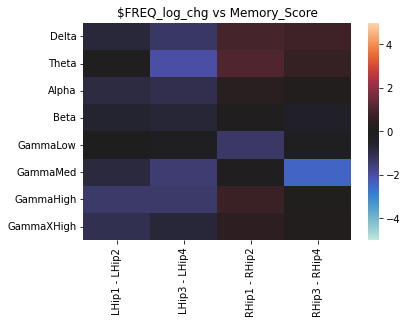

In [ ]:
make_heatmap(power_mem_trial, '$FREQ_log_chg', 'Memory_Score')

RHip1 - RHip2 Delta: r = -0.3017461591941914, p = 0.021338183133688172
RHip1 - RHip2 Alpha: r = -0.2634716568270824, p = 0.04568181763759358
RHip1 - RHip2 Beta: r = -0.2819132045010935, p = 0.03203743576492514
RHip3 - RHip4 Delta: r = -0.3514177953218534, p = 0.013288071435225991


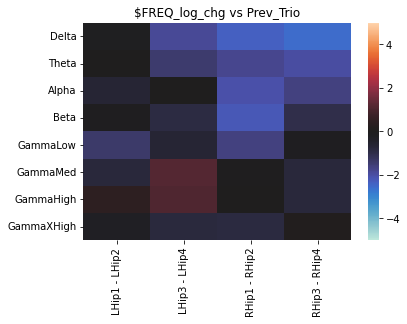

In [ ]:
make_heatmap(power_mem_3, '$FREQ_log_chg', 'Prev_Trio')

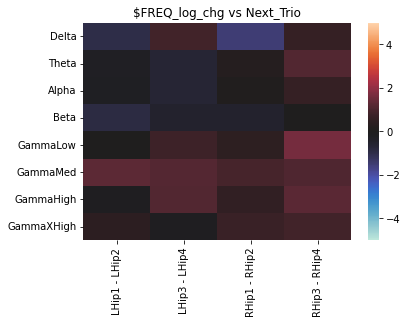

In [ ]:
make_heatmap(power_mem_3, '$FREQ_log_chg', 'Next_Trio')

## POST-Stim Power

LHip3 - LHip4 Delta: r = -0.48131860083754907, p = 0.04314368915195751
LHip3 - LHip4 Theta: r = -0.5263739038153527, p = 0.024828144035354254
RHip1 - RHip2 GammaMed: r = 0.5348268877420973, p = 0.022202996645914023


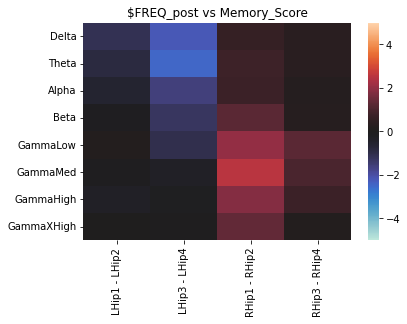

In [ ]:
make_heatmap(power_mem_trial, '$FREQ_post', 'Memory_Score')

LHip3 - LHip4 Delta: r = -0.3387639985061827, p = 0.00928997120962828
LHip3 - LHip4 Theta: r = -0.32489385211489613, p = 0.012833190350609515
LHip3 - LHip4 Alpha: r = -0.3286685577546354, p = 0.01176939173565161
LHip3 - LHip4 Beta: r = -0.3486142143207956, p = 0.00732113750976252
LHip3 - LHip4 GammaLow: r = -0.26142037304391186, p = 0.04745728494689235


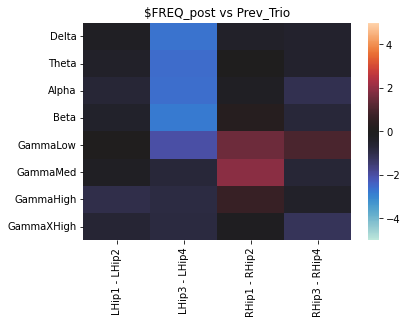

In [ ]:
make_heatmap(power_mem_3, '$FREQ_post', 'Prev_Trio')

LHip1 - LHip2 Delta: r = -0.38242087856997986, p = 0.0030511845495161346
LHip1 - LHip2 Theta: r = -0.32821092931222706, p = 0.011894168706362005
LHip3 - LHip4 Theta: r = -0.3275406310032418, p = 0.01207899124962671
RHip1 - RHip2 Beta: r = 0.32201438907705826, p = 0.013699391351325429
RHip1 - RHip2 GammaLow: r = 0.5445235926291967, p = 9.92886851431459e-06
RHip1 - RHip2 GammaMed: r = 0.47221889806397266, p = 0.00018222516678847962
RHip1 - RHip2 GammaHigh: r = 0.31598079865851586, p = 0.01567848516823266
RHip3 - RHip4 Delta: r = 0.31641824622991754, p = 0.026759869400008858
RHip3 - RHip4 Theta: r = 0.32706350953516977, p = 0.021800372232496614
RHip3 - RHip4 GammaLow: r = 0.4458539084293326, p = 0.0013243406141533168
RHip3 - RHip4 GammaMed: r = 0.2901668116812999, p = 0.04312721831429723


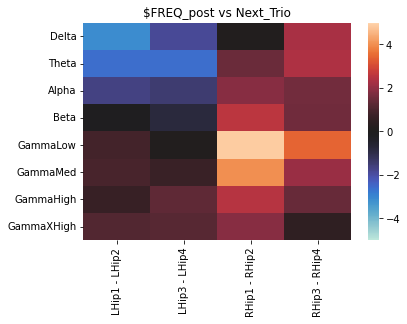

In [ ]:
make_heatmap(power_mem_3, '$FREQ_post', 'Next_Trio')

messing around

(array([ 4., 50., 71., 93., 99., 71., 37., 26., 12.,  5.]),
 array([-9.60204614, -9.22639958, -8.85075302, -8.47510647, -8.09945991,
        -7.72381335, -7.3481668 , -6.97252024, -6.59687368, -6.22122713,
        -5.84558057]),
 <BarContainer object of 10 artists>)

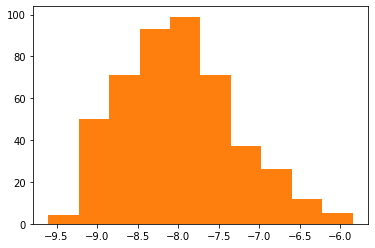

In [ ]:
fig, ax = plt.subplots()

ax.hist(np.log10(power_log_chg['Theta_post']))

plc = pd.read_csv('pre_post_stim.csv')
ax.hist(np.log10(plc['Theta_post']))

In [ ]:
hand_calc = power_log_chg.copy()
stored = plc.copy()
stored['Stim_Num'] += 1

In [ ]:
pd.concat([hand_calc, stored]).drop_duplicates(['ID', 'Trial', 'Channel', 'Stim_Num'], keep=False)

ID  Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100      1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100      1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
2    100      1  LatT1 - LatT2  1.378031e-09  2.185936e-09  1.179630e-09   
3    100      1  LatT3 - LatT4  8.129781e-08  7.790410e-09  4.389105e-09   
16   100      2  LHip1 - LHip2  6.111540e-08  3.771269e-08  2.708512e-08   
..   ...    ...            ...           ...           ...           ...   
459  202      2    LHT3 - LHT4  1.518380e-08  2.126930e-09  3.240071e-09   
464  202      3    LOT1 - LOT2  3.550790e-08  1.153714e-08  2.278720e-09   
465  202      3    LOT3 - LOT4  9.146609e-09  6.811802e-09  3.374165e-09   
466  202      3    LHT1 - LHT2  1.318418e-09  1.206045e-09  9.419762e-10   
467  202      3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
2    2.098490e-10    1.228712e-11   4.416371e-11   1.970511e-11  ...   
3    1.734181e-09    3.738994e-11   2.994732e-10   5.937977e-11  ...   
16   1.352690e-08    9.112087e-11   7.153666e-10   2.447149e-10  ...   
..            ...             ...            ...            ...  ...   
459  5.832078e-10    1.252654e-11   3.258594e-11   1.048236e-11  ...   
464  2.943730e-09    2.888773e-11   3.305943e-10   1.487729e-10  ...   
465  2.080614e-09    4.543147e-11   1.954827e-10   4.527764e-11  ...   
466  6.011702e-10    1.193692e-11   6.070554e-11   2.430652e-11  ...   
467  5.998392e-10    1.263479e-11   4.582474e-11   1.437073e-11  ...   

     GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  \
0    2.448737e-10    3.160809e-11       0.172679      -0.046258   
1    8.771663e-11    2.150510e-11       0.697190       0.141332   
2    1.546049e-11    7.259526e-12      -0.110548       0.050514   
3    4.948296e-11    2.017395e-11       0.883454      -0.306906   
16   2.789658e-10    3.096874e-11      -0.058003      -0.223956   
..            ...             ...            ...            ...   
459  1.385542e-11    6.421238e-12       0.630400       0.462898   
464  6.489303e-11    1.398333e-11       0.362258      -0.006381   
465  7.123105e-11    9.480527e-12       0.065842       0.045289   
466  2.610208e-11    8.207254e-12      -0.117596      -0.105110   
467  1.963331e-11    6.364368e-12       0.564010      -0.530514   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.126444     -0.027167         -0.000208          0.235129   
2         0.177617     -0.067019         -0.056950          0.105356   
3        -0.310061      0.078600          0.134880          0.079183   
16       -0.033788     -0.045275         -0.172873         -0.056891   
..             ...           ...               ...               ...   
459       0.234890     -0.069142         -0.149169         -0.121160   
464      -0.222434      0.229174          0.100273          0.360326   
465       0.021033      0.059923         -0.012712         -0.196786   
466       0.172754     -0.064298         -0.152160         -0.030952   
467       0.166849      0.232527          0.016653         -0.135515   

     GammaHigh_log_chg  GammaXHigh_log_chg  
0            -0.134723            0.111894  
1             0.192664            0.121860  
2             0.030603            0.082202  
3             0.190453            0.049423  
16           -0.163039            0.040121  
..                 ...                 ...  
459           0.230389            0.089655  
464           0.100764           -0.153230  
465           0.191675           -0.154657  
466          -0.088260           -0.057565  
467           0.078629            0.091936  

[280 rows x 28 co

In [ ]:
merged = hand_calc.merge(stored, on=['ID', 'Trial', 'Channel', 'Stim_Num'], indicator=True, how='outer')

In [ ]:
merged['_merge'].value_counts()

both          328
left_only     140
right_only    140
Name: _merge, dtype: int64

In [ ]:
merged[merged['_merge'] == 'left_only'][['ID', 'Trial', 'Channel', 'Stim_Num', 'Delta_post_x']]

ID  Trial        Channel  Stim_Num  Delta_post_x
0    100      1  LHip1 - LHip2         0  1.142425e-07
1    100      1  LHip3 - LHip4         0  3.784396e-07
2    100      1  LatT1 - LatT2         0  1.378031e-09
3    100      1  LatT3 - LatT4         0  8.129781e-08
16   100      2  LHip1 - LHip2         0  6.111540e-08
..   ...    ...            ...       ...           ...
451  202      2    LHT3 - LHT4         0  3.282836e-09
460  202      3    LOT1 - LOT2         2  3.962035e-09
461  202      3    LOT3 - LOT4         2  6.539377e-09
462  202      3    LHT1 - LHT2         2  1.572392e-09
463  202      3    LHT3 - LHT4         2  1.140535e-08

[140 rows x 5 columns]

In [ ]:
merged[merged['_merge'] == 'right_only'][['ID', 'Trial', 'Channel', 'Stim_Num', 'Delta_post_x']]

ID  Trial        Channel  Stim_Num  Delta_post_x
468  100      1  LHip1 - LHip2         4           NaN
469  100      1  LHip3 - LHip4         4           NaN
470  100      1  LatT1 - LatT2         4           NaN
471  100      1  LatT3 - LatT4         4           NaN
472  100      2  LHip1 - LHip2         4           NaN
..   ...    ...            ...       ...           ...
603  202      2    LHT3 - LHT4         3           NaN
604  202      3    LOT1 - LOT2         4           NaN
605  202      3    LOT3 - LOT4         4           NaN
606  202      3    LHT1 - LHT2         4           NaN
607  202      3    LHT3 - LHT4         4           NaN

[140 rows x 5 columns]

In [ ]:
len(plc), len(power_log_chg)

(468, 468)

In [ ]:
power_log_chg.head()

ID  Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0  100      1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1  100      1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
2  100      1  LatT1 - LatT2  1.378031e-09  2.185936e-09  1.179630e-09   
3  100      1  LatT3 - LatT4  8.129781e-08  7.790410e-09  4.389105e-09   
4  100      1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   

      Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0  1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1  3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
2  2.098490e-10    1.228712e-11   4.416371e-11   1.970511e-11  ...   
3  1.734181e-09    3.738994e-11   2.994732e-10   5.937977e-11  ...   
4  8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   

   GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  Alpha_log_chg  \
0  2.448737e-10    3.160809e-11       0.172679      -0.046258      -0.186435   
1  8.771663e-11    2.150510e-11       0.697190       0.141332      -0.126444   
2  1.546049e-11    7.259526e-12      -0.110548       0.050514       0.177617   
3  4.948296e-11    2.017395e-11       0.883454      -0.306906      -0.310061   
4  5.778968e-10    4.162106e-11       0.439985       0.037215      -0.182963   

   Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  GammaHigh_log_chg  \
0     -0.062647         -0.010354          0.110085          -0.134723   
1     -0.027167         -0.000208          0.235129           0.192664   
2     -0.067019         -0.056950          0.105356           0.030603   
3      0.078600          0.134880          0.079183           0.190453   
4      0.020740         -0.115489         -0.307307           0.136379   

   GammaXHigh_log_chg  
0            0.111894  
1            0.121860  
2            0.082202  
3            0.049423  
4           -0.060573  

[5 rows x 28 columns]

# Final Grid

In [ ]:
import importlib
import stats_pipeline
importlib.reload(stats_pipeline)

<module 'stats_pipeline' from 'c:\\Users\\seand\\eeg_proj\\ecog\\stats_pipeline.py'>

$FREQ_pre Memory_Score
RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaMed: r = 0.7886304209812275, p = 0.00010069993500367756
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaMed: r = 0.6216978166665508, p = 0.013350208341817537
$FREQ_pre Prev_Trio
$FREQ_pre Next_Trio
RHip1 - RHip2 GammaLow: r = 0.5650579157431345, p = 0.00760504421129645
RHip1 - RHip2 GammaMed: r = 0.49276575867250605, p = 0.02323434739574144
$FREQ_log_chg Memory_Score
RHip3 - RHip4 GammaMed: r = -0.5628382081997695, p = 0.028931863752304884
$FREQ_log_chg Prev_Trio
RHip1 - RHip2 Alpha: r = -0.4387955679870388, p = 0.04659862826809577
RHip3 - RHip4 Delta: r = -0.5218646501835278, p = 0.026324269172668353
$FREQ_log_chg Next_Trio
$FREQ_post Memory_Score
LHip3 - LHip4 Delta: r = -0.49365204632389187, p = 0.03734199954684434
LHip3 - LHip4 Theta: r = -0.508469275522

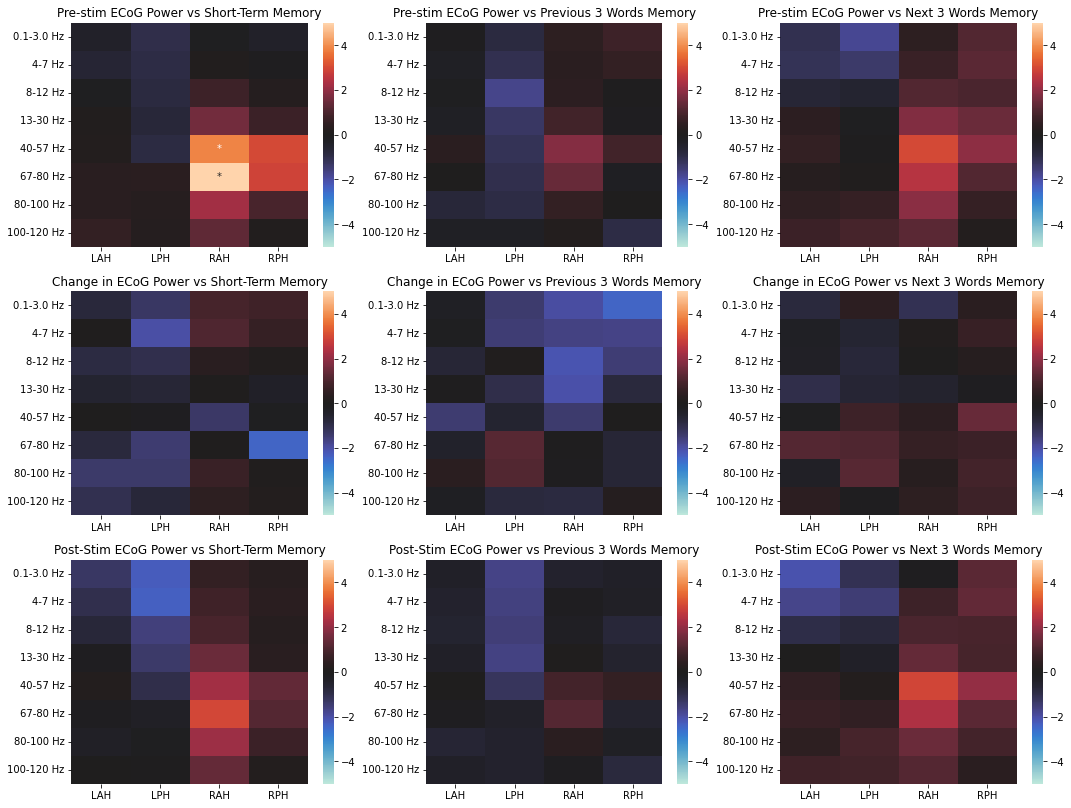

In [127]:
from stats_pipeline import make_heatmap_linreg
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(18, 14)
xs = ['$FREQ_pre', '$FREQ_log_chg', '$FREQ_post']
xlabels = ['Pre-stim ECoG Power', 'Change in ECoG Power', 'Post-Stim ECoG Power']
ys = ['Memory_Score', 'Prev_Trio', 'Next_Trio']
ylabels = ['Short-Term Memory', 'Previous 3 Words Memory', 'Next 3 Words Memory']
for i in range(3):
    for j in range(3):
        df = power_mem_trial if j == 0 else power_mem_3
        print(xs[i], ys[j])
        make_heatmap_linreg(df, xs[i], ys[j], freqs, xlabels[i], ylabels[j], ax=axs[i][j])

# Mixed

In [128]:
import importlib
import stats_pipeline
importlib.reload(stats_pipeline)

<module 'stats_pipeline' from 'c:\\Users\\seand\\eeg_proj\\ecog\\stats_pipeline.py'>

$FREQ_pre Memory_Score
RHip1 - RHip2 GammaLow: 0.0002397118569351919
RHip1 - RHip2 GammaMed: 7.5369301775209755e-06
RHip3 - RHip4 GammaLow: 0.024664668741365567
RHip3 - RHip4 GammaMed: 0.00833032648302603
$FREQ_pre Prev_Trio


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

$FREQ_pre Next_Trio
RHip1 - RHip2 GammaLow: 0.007462712987041906
RHip1 - RHip2 GammaMed: 0.030110828229510115
$FREQ_log_chg Memory_Score
RHip3 - RHip4 GammaLow: 0.006868589846089243
RHip3 - RHip4 GammaMed: 0.007581154451639835
$FREQ_log_chg Prev_Trio
RHip1 - RHip2 Alpha: 0.038026901835316144
RHip3 - RHip4 Delta: 0.006430447928496817
RHip3 - RHip4 Theta: 0.033790454710022864
$FREQ_log_chg Next_Trio
$FREQ_post Memory_Score
RHip1 - RHip2 GammaMed: 0.012366588567804116
$FREQ_post Prev_Trio


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

$FREQ_post Next_Trio
LHip1 - LHip2 Delta: 0.03825573516272247


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RHip1 - RHip2 GammaLow: 0.008105226659632595
RHip1 - RHip2 GammaMed: 0.038051156157230585


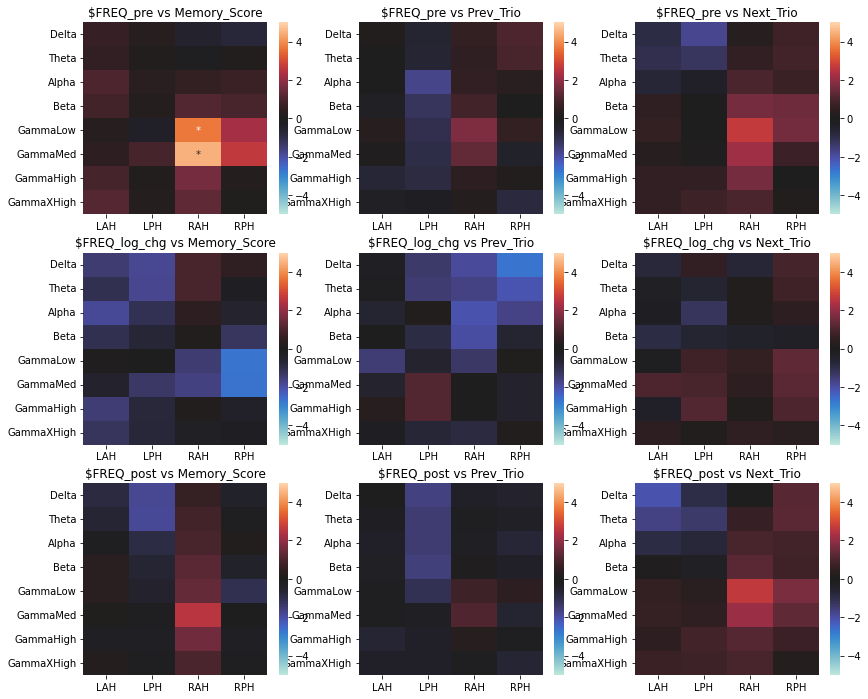

In [129]:
from stats_pipeline import make_heatmap_mixed

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(14, 12)
xs = ['$FREQ_pre', '$FREQ_log_chg', '$FREQ_post']
ys = ['Memory_Score', 'Prev_Trio', 'Next_Trio']
for i in range(3):
    for j in range(3):
        df = power_mem_trial if j == 0 else power_mem_3
        print(xs[i], ys[j])
        make_heatmap_mixed(df, xs[i], ys[j], freqs, ax=axs[i][j])

# Kendall Tau

In [130]:
import importlib
import stats_pipeline
importlib.reload(stats_pipeline)

<module 'stats_pipeline' from 'c:\\Users\\seand\\eeg_proj\\ecog\\stats_pipeline.py'>

$FREQ_pre Memory_Score
RHip1 - RHip2 GammaLow: T = 0.4963415681134366, p = 0.006515818627316392
RHip1 - RHip2 GammaMed: T = 0.58142869407574, p = 0.0014374658371743639
RHip3 - RHip4 GammaLow: T = 0.4526231598888029, p = 0.02537253820804236
RHip3 - RHip4 GammaMed: T = 0.4526231598888029, p = 0.02537253820804236
$FREQ_pre Prev_Trio
LHip3 - LHip4 Alpha: T = -0.39007337609021714, p = 0.024999535017333728
$FREQ_pre Next_Trio
LHip3 - LHip4 Delta: T = -0.3842906776055266, p = 0.026148622744391076
LHip3 - LHip4 Theta: T = -0.41722987854314314, p = 0.015751387326974012
RHip1 - RHip2 GammaLow: T = 0.4949015419574727, p = 0.004073522836298109
RHip1 - RHip2 GammaMed: T = 0.4405167571269812, p = 0.01056515372480251
$FREQ_log_chg Memory_Score
LHip3 - LHip4 GammaMed: T = -0.35486043161491804, p = 0.049422044919127155
RHip3 - RHip4 GammaMed: T = -0.5143444998736397, p = 0.011067859847516674
$FREQ_log_chg Prev_Trio
RHip3 - RHip4 Delta: T = -0.44548927337062816, p = 0.01911168164129246
$FREQ_log_chg Nex

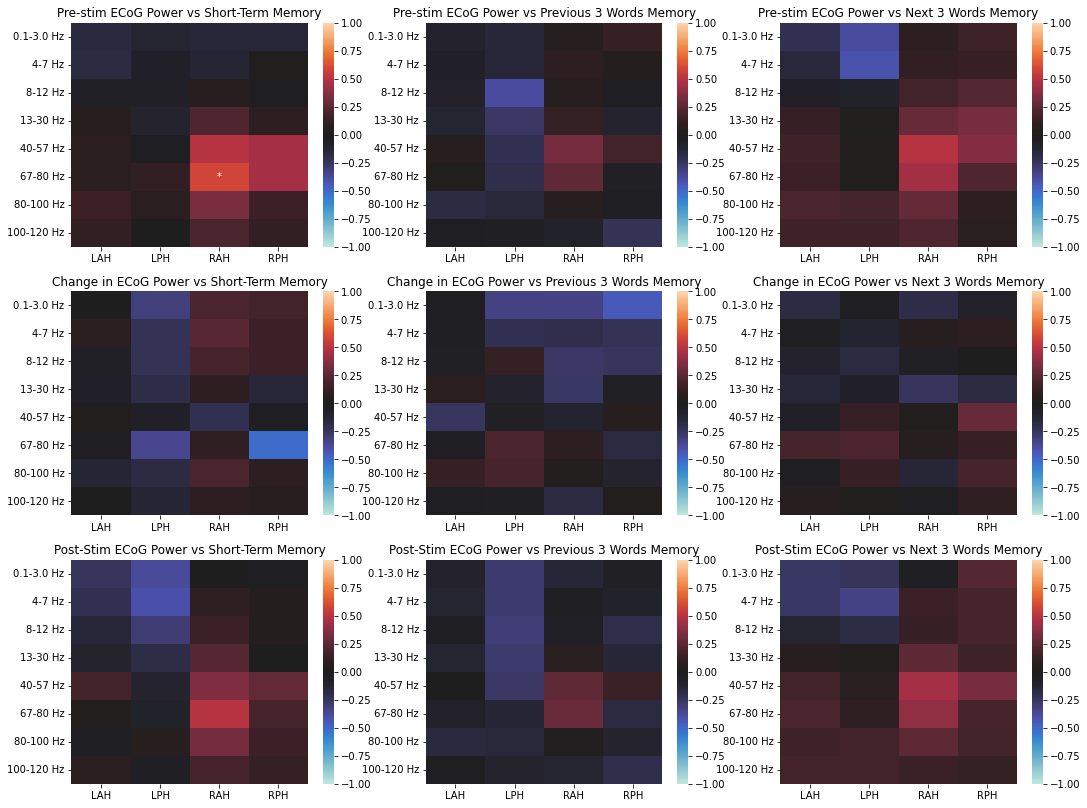

In [131]:
from stats_pipeline import make_heatmap_kendalltau
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(18, 14)
xs = ['$FREQ_pre', '$FREQ_log_chg', '$FREQ_post']
xlabels = ['Pre-stim ECoG Power', 'Change in ECoG Power', 'Post-Stim ECoG Power']
ys = ['Memory_Score', 'Prev_Trio', 'Next_Trio']
ylabels = ['Short-Term Memory', 'Previous 3 Words Memory', 'Next 3 Words Memory']
for i in range(3):
    for j in range(3):
        df = power_mem_trial if j == 0 else power_mem_3
        print(xs[i], ys[j])
        make_heatmap_kendalltau(df, xs[i], ys[j], freqs, xlabels[i], ylabels[j], ax=axs[i][j])